# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier



In [1]:
import pickle
import matplotlib.pyplot as plt
import csv
import math
import numpy as np
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
import time

---
## Step 0: Load The Data

In [55]:
# Load pickled data
import pickle

data_path = 'data/'
training_file = data_path + 'train.p'
validation_file= data_path + 'valid.p'
testing_file = data_path + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

In [56]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of test examples
n_test = X_test.shape

# Shape of an traffic sign image
image_shape = X_train.shape[1:]

# Unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = (12630, 32, 32, 3)
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s).

In [4]:
# Visualizations will be shown in the notebook.
%matplotlib inline

In [74]:
def dataset_stat(features, labels):
    """
    Generate a histogram of count for different signs and map to one image of the kind
    """
    histogram = [0] * n_classes
    sample_images = [None] * n_classes
    for idx, l in enumerate(labels):
        histogram[l] += 1
        if sample_images[l] is None:
            sample_images[l] = features[idx]
            
    return histogram, sample_images

def print_sample_image(img, label=None):
    """
    Plot a sample image
    """
    if label:
        print(signname[label])
    if len(img.shape) == 3 and img.shape[2] == 3:
        plt.imshow(img)
    else:
        plt.imshow(img.squeeze(), cmap='gray')

# load human readable sign name        
sign_names = [None] * n_classes
with open(data_path + 'signnames.csv', 'r') as f:
    reader = csv.reader(f)
    for r in reader:
        if r[0].isdigit():
            sign_names[int(r[0])] = r[1]
            
def get_sign_name(sign_idx):
    return sign_names[sign_idx]

def explore(features, labels):
    figsize_default = plt.rcParams['figure.figsize']

    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    histogram, sample_images = dataset_stat(features, labels)
    ncols = 4
    nrows = math.ceil(n_classes / 4)

    _, axes = plt.subplots(nrows=nrows, ncols=ncols)
    class_idx = 0
    for r in range(nrows):
        for c in range(ncols):
            a = axes[r][c]
            a.axis('off')
            if class_idx < n_classes:
                if histogram[class_idx] != 0:
                    a.imshow(sample_images[class_idx])
                a.set_title("No.{} {}(#{})".format(class_idx, get_sign_name(class_idx), histogram[class_idx]), fontsize=12)
                class_idx += 1

    plt.rcParams['figure.figsize'] = figsize_default

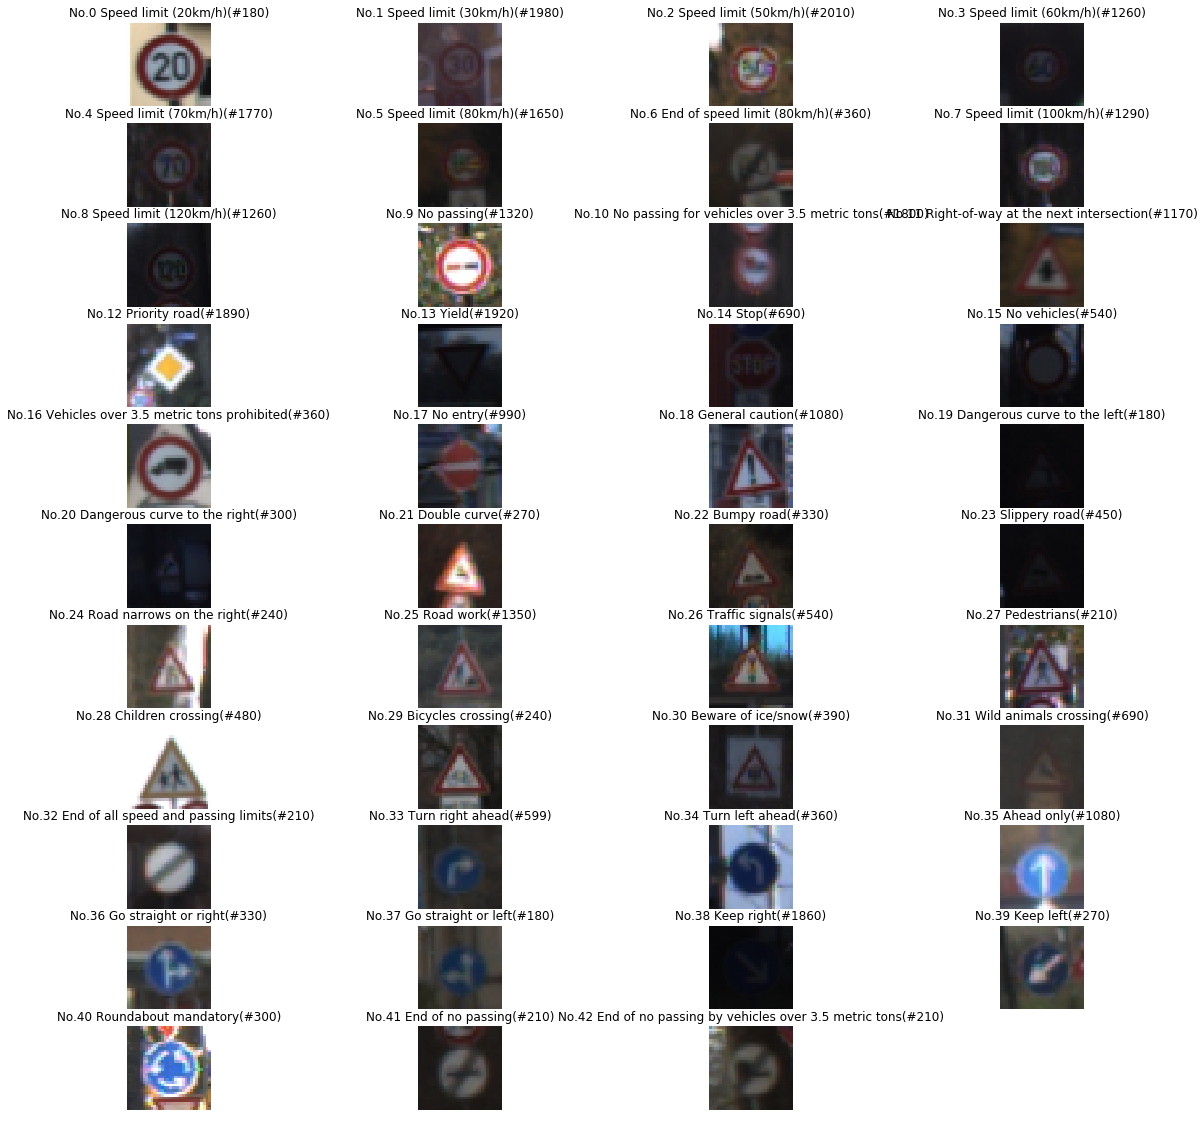

In [60]:
# Explore the training set
explore(X_train, y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [81]:
def resize(img):
    return cv2.resize(img, (32, 32))

def normalize(img):
    return np.array(img / 255, dtype=np.float32)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def preprocess(images):
    return np.array([normalize(grayscale(resize(img))).reshape(32, 32, 1) for img in images])

In [35]:
# Preprocess datasets
prep_X_train = preprocess(X_train)
prep_X_valid = preprocess(X_valid)
prep_X_test = preprocess(X_test)

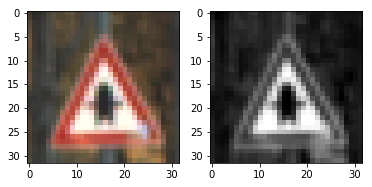

In [36]:
# Compare raw image and preprocessed image
_, vframes = plt.subplots(nrows=1, ncols=2)
vframes[0].imshow(X_train[8888])
vframes[1].imshow(prep_X_train[8888].squeeze(), cmap='gray')

### Model Architecture

I use a modified version of LeNet architecture:
    
    2 covn layers -> 1 flatten layer -> 4 fully connected linear layer
    
Detail View:
    
* conv 1:   
    * conv 32x32x1 -> 28x28x12
    * relu6
    * Pooling 28x28x12 -> 14x14x12
* conv 2:
    * conv 14x14x12 -> 10x10x24
    * relu6
    * Pooling 10x10x24 -> 5x5x24
* flatten:  5x5x24 -> 600
* drop out: 600 -> 600
* linear 1: 600 -> 344 -> relu6
* linear 2: 344 -> 172 -> relu6
* linear 3: 172 -> 86 -> relu6
* linear 4: 86 -> 43

In [40]:
mu, sigma = 0, 0.1

# Define generic layers to reduce code
def conv(x, out_W, out_H, out_D):
    in_W, in_H, in_D = map(int, x.shape[1:])
    # we assume stride is 1
    strides = [1,1,1,1]
    f_W = in_W - out_W + 1
    f_H = in_H - out_H + 1
    
    W = tf.Variable(tf.truncated_normal(shape=(f_H, f_W, in_D, out_D), mean=mu, stddev=sigma))
    b = tf.Variable(tf.zeros(out_D))
    return tf.nn.conv2d(x, W, strides=strides, padding='VALID') + b

def linear(x, out_size):
    in_size = x.shape.as_list()[1]
    W = tf.Variable(tf.truncated_normal(shape=(in_size, out_size), mean=mu, stddev=sigma))
    b = tf.Variable(tf.zeros(out_size))
    return tf.matmul(x, W) + b

# Define the CNN
def my_net(X, keep_prod):
    # Layer1
    conv1 = conv(X, 28, 28, 12)
    conv1 = tf.nn.relu6(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Layer2
    conv2 = conv(conv1, 10, 10, 24)
    conv2 = tf.nn.relu6(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Layer3
    flat = tf.contrib.layers.flatten(conv2)
    dropped = tf.nn.dropout(flat, keep_prob)
    linear1 = linear(dropped, 344)
    linear1 = tf.nn.relu6(linear1)
    
    # Layer4
    linear2 = linear(linear1, 172)
    linear2 = tf.nn.relu6(linear2)
    
    ## Layer5
    linear3 = linear(linear2, 86)
    linear3 = tf.nn.relu6(linear3)
    
    ## Layer6
    linear4 = linear(linear2, n_classes)
    return linear4

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [20]:
# Define model parameters
features = tf.placeholder(tf.float32, shape=(None,)+prep_X_train.shape[1:])
labels = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(labels, n_classes)
keep_prob = tf.placeholder(tf.float32)
logits = my_net(features, keep_prob)

In [21]:
prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
get_accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

def evaluate(X, y):
    num_samples = len(X)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_samples, batch_size):
        end = offset + batch_size
        X_batch, y_batch = X[offset:end], y[offset:end]
        accuracy = sess.run(get_accuracy, feed_dict={features: X_batch, labels: y_batch, keep_prob: 1.0})
        total_accuracy += (accuracy * len(X_batch))
    return total_accuracy / num_samples

In [46]:
# Define training parameters
batch_size = 128
epoch = 50
rate = 0.001
model_path = './models/mynet'

# Defind training goal
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,logits=logits)
loss_func = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
goal = optimizer.minimize(loss_func)

saver = tf.train.Saver()
def train_goal(X, y):
    num_samples = len(X)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print("start training...")
        for i in range(epoch):
            _X, _y = shuffle(X, y)
            begin_time = time.time()
            for offset in range(0, num_samples, batch_size):
                end = offset + batch_size
                X_batch, y_batch = _X[offset:end], _y[offset:end]
                sess.run(goal, feed_dict={features: X_batch, labels: y_batch, keep_prob: 0.8})
        
            validation = evaluate(prep_X_valid, y_valid)
            print("[{3:.1f}s] epoch {0}/{1}: validation accuracy = {2:.3f}".format(i+1, epoch, validation, time.time()-begin_time))

        saver.save(sess, model_path);
        print("model saved into {}".format(model_path))

In [49]:
# Start training
train_goal(prep_X_train, y_train)

start training...
[1.1s] epoch 1/50: validation accuracy = 0.724
[1.1s] epoch 2/50: validation accuracy = 0.829
[1.1s] epoch 3/50: validation accuracy = 0.884
[1.1s] epoch 4/50: validation accuracy = 0.907
[1.1s] epoch 5/50: validation accuracy = 0.926
[1.1s] epoch 6/50: validation accuracy = 0.913
[1.1s] epoch 7/50: validation accuracy = 0.925
[1.1s] epoch 8/50: validation accuracy = 0.927
[1.1s] epoch 9/50: validation accuracy = 0.922
[1.1s] epoch 10/50: validation accuracy = 0.921
[1.1s] epoch 11/50: validation accuracy = 0.939
[1.1s] epoch 12/50: validation accuracy = 0.932
[1.1s] epoch 13/50: validation accuracy = 0.932
[1.1s] epoch 14/50: validation accuracy = 0.937
[1.1s] epoch 15/50: validation accuracy = 0.934
[1.1s] epoch 16/50: validation accuracy = 0.937
[1.1s] epoch 17/50: validation accuracy = 0.933
[1.1s] epoch 18/50: validation accuracy = 0.944
[1.1s] epoch 19/50: validation accuracy = 0.938
[1.1s] epoch 20/50: validation accuracy = 0.941
[1.1s] epoch 21/50: validation 

In [50]:
## Evaluate on TEST set
with tf.Session() as sess:
    saver.restore(sess, model_path)
    accuracy = evaluate(prep_X_test, y_test)
    print("model accuracy: {:.3f}".format(accuracy))

INFO:tensorflow:Restoring parameters from ./models/mynet
model accuracy: 0.935


---

## Step 3: Test a Model on New Images

Here we use GTSRB Final-Test dataset.

### Load and Output the Images

In [85]:
GTSRB_path = data_path + 'GTSRB/Final_Test/Images/'
X_gt = []
y_gt = []
with open(GTSRB_path + 'GT-final_test.csv') as gt_file:
    gt_reader = csv.reader(gt_file, delimiter=';')
    next(gt_reader, None)  # skip the headers
    for row in gt_reader:
        X_gt.append(plt.imread(GTSRB_path + row[0]))
        y_gt.append(int(row[7]))
X_gt = np.array(X_gt)
y_gt = np.array(y_gt)

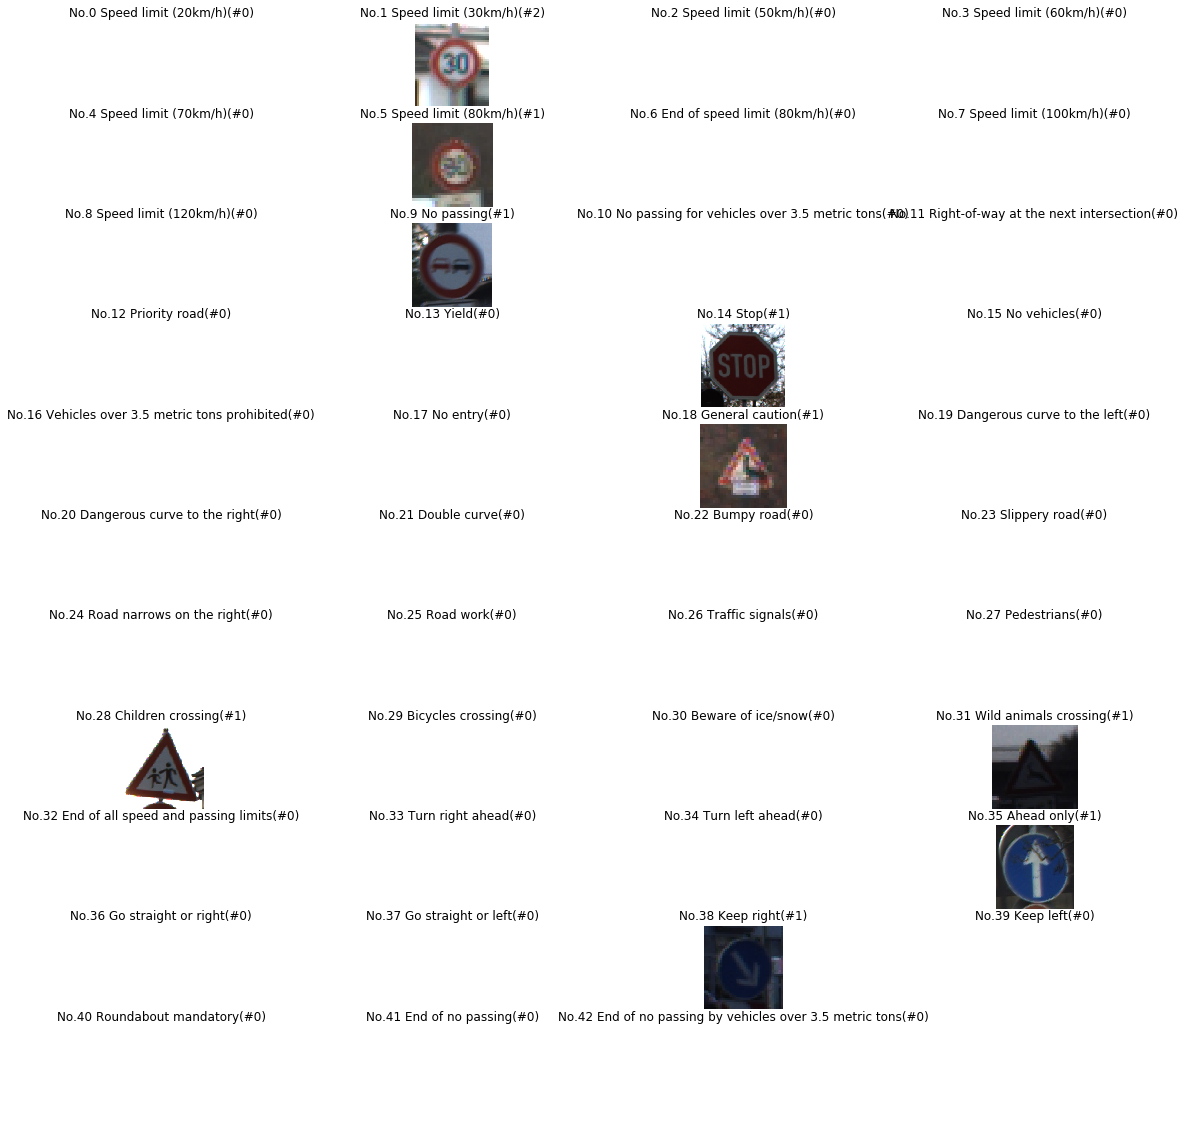

In [91]:
# randomly sample 10 images
idx = np.random.choice(np.arange(len(X_gt)), 10, replace=False)
X_sample = X_gt[idx]
y_sample = y_gt[idx]
explore(X_sample, y_sample)

### Predict the Sign Type for Each Image

In [92]:
### Use the model to output the prediction for each image.
prep_X_sample = preprocess(X_sample)

with tf.Session() as sess:
    saver.restore(sess, model_path)
    prediction = sess.run(tf.argmax(logits, 1), {features: prep_X_sample, keep_prob: 1.0})
    results = [get_sign_name(p) for p in prediction]

print(results)

INFO:tensorflow:Restoring parameters from ./models/mynet
['Stop', 'Speed limit (30km/h)', 'Ahead only', 'Speed limit (30km/h)', 'No passing', 'Wild animals crossing', 'Children crossing', 'Keep right', 'Speed limit (80km/h)', 'Right-of-way at the next intersection']


### Analyze Performance

In [93]:
### Calculate the accuracy for new images. 
with tf.Session() as sess:
    saver.restore(sess, model_path)
    accuracy = evaluate(prep_X_sample, y_sample)
    print("model accuracy: {:.3f}".format(accuracy))

INFO:tensorflow:Restoring parameters from ./models/mynet
model accuracy: 0.900


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [103]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
def topkv(X):
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        pred = tf.nn.softmax(logits)
        results = sess.run(tf.nn.top_k(pred, k=5), {features: X, keep_prob: 1.0})
        return results

_, train_sample_images = dataset_stat(X_train, y_train)
def explore_topkv(X, topkv):
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    ncols = len(topkv.values[0])+1
    nrows = len(topkv.values)
    _, axes = plt.subplots(nrows=nrows, ncols=ncols)
    
    for r, img in enumerate(X):
        for c in range(ncols):
            axes[r][c].axis('off')
        cur = axes[r][0]
        cur.imshow(img)
        cur.set_title("Provided Image")
        
        # show the top five softmax prob
        for c, prob in enumerate(topkv.values[r]):
            cur = axes[r][c+1]
            class_idx = topkv.indices[r][c]
            sample = train_sample_images[class_idx]
            cur.imshow(sample)
            cur.set_title("{} ({:.2f})".format(get_sign_name(class_idx), prob))
    plt.rcParams['figure.figsize'] = figsize_default

INFO:tensorflow:Restoring parameters from ./models/mynet


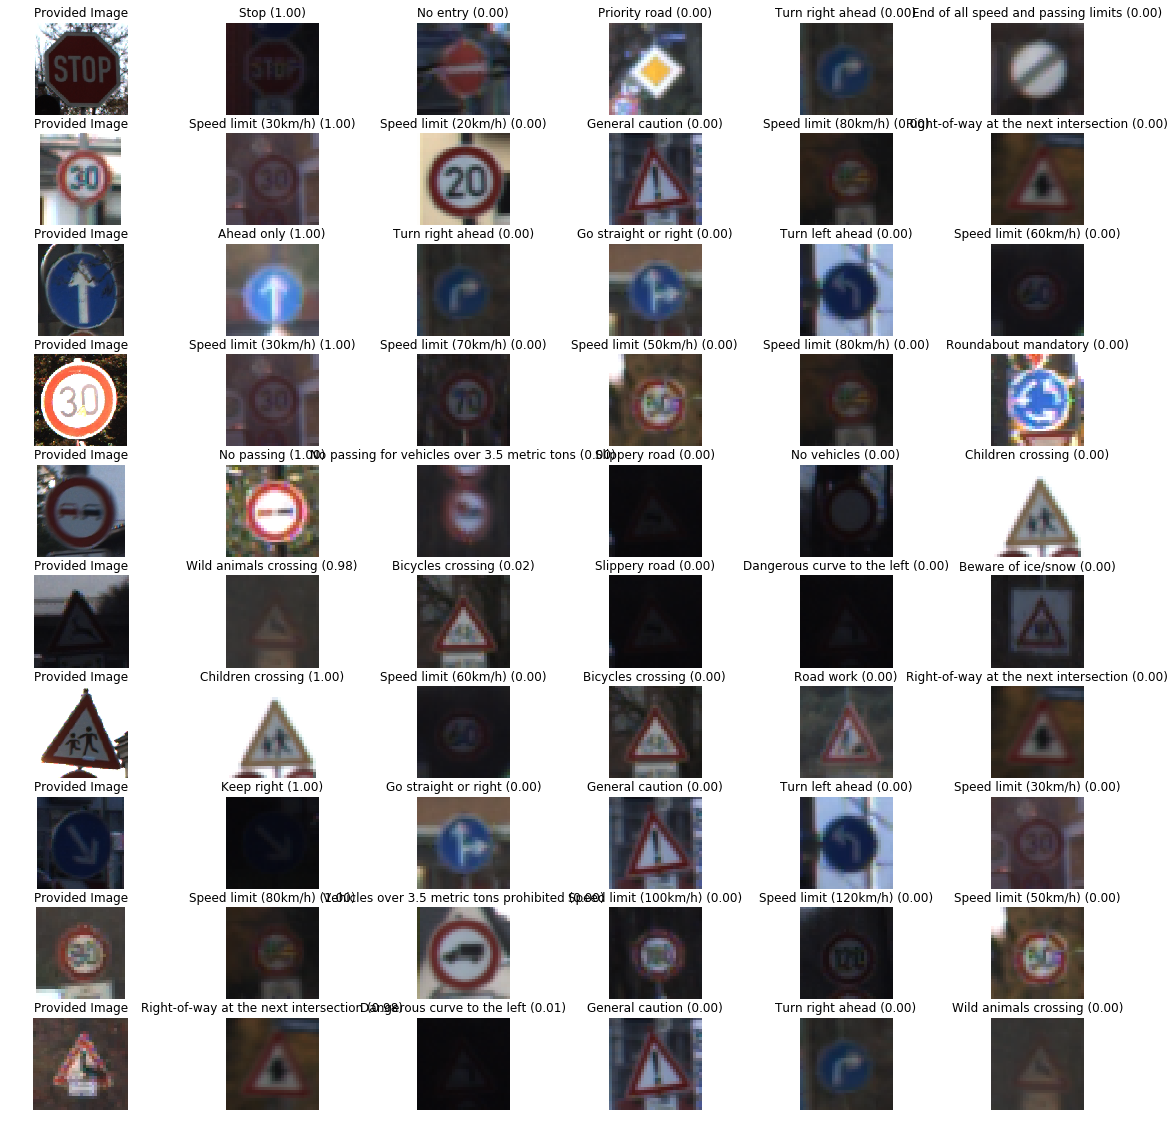

In [104]:
explore_topkv(X_sample, topkv(prep_X_sample))